In [94]:
import pandas as pd
from datetime import timedelta

# Constante variabelen
ENERGIE_VERBRUIK_PER_KM = 1.2  # kWh per gereden kilometer
OPLAADKRACHT_PER_UUR = 450  # kWh per uur tot 90%
MAX_BATT_CAPA = 300  # kWh
SOC_START = 0.9  # factor
SOC_MIN = 0.1  # factor
BATTERIJ_SLIJTAGE = 0.9  # Factor
SOH = MAX_BATT_CAPA * BATTERIJ_SLIJTAGE

def load_data():
    """Functie om data in te laden."""
    df_omloopplanning = pd.read_excel('omloopplanning.xlsx', engine='openpyxl')
    df_dienstregeling = pd.read_excel('Connexxion data - 2024-2025.2.xlsx', engine='openpyxl')
    df_afstandsmatrix = pd.read_excel('Connexxion data - 2024-2025.2.xlsx', engine='openpyxl', sheet_name='Afstandsmatrix')
    return df_omloopplanning, df_dienstregeling, df_afstandsmatrix

def create_parameters_df():
    """Functie om een parameters DataFrame te maken."""
    soc_ochtend = SOH * SOC_START
    soc_minimum = SOH * SOC_MIN
    data = {
        'Parameter': ['Max Batterij Capaciteit', 'SOC Start', 'SOC Minimum', 'Batterij Slijtage', 'SOH', 'SOC Ochtend', 'SOC Minimum', 'Batterijverbuik', 'Oplaadsnelheid'],
        'Waarde': [MAX_BATT_CAPA, SOC_START, SOC_MIN, BATTERIJ_SLIJTAGE, SOH, soc_ochtend, soc_minimum, ENERGIE_VERBRUIK_PER_KM, OPLAADKRACHT_PER_UUR],
        'Eenheid': ['kWh', 'Factor', 'Factor', 'Factor', 'kW (MBC * BS)', 'kW (SOH * SOC S)', 'kW (SOH * SOC M)', 'kWh/km', 'kWh/uur']
    }
    return pd.DataFrame(data)

def convert_to_datetime(time_str):
    """Functie om tijden naar datetime om te zetten."""
    if pd.isna(time_str):
        # Als de tijd ontbreekt, retourneer een NaT Timestamp
        return pd.NaT

    try:
        time_obj = pd.to_datetime(time_str, format='%H:%M').time()
    except TypeError:
        # Fallback als time_str geen geschikt formaat heeft
        return pd.NaT

    upper_boundary = pd.to_datetime('23:59', format='%H:%M').time()
    lower_boundary = pd.to_datetime('04:00', format='%H:%M').time()
    
    if lower_boundary <= time_obj <= upper_boundary:
        return pd.Timestamp('2024-08-29') + pd.Timedelta(hours=time_obj.hour, minutes=time_obj.minute)
    else:
        return pd.Timestamp('2024-08-30') + pd.Timedelta(hours=time_obj.hour, minutes=time_obj.minute)

def process_schedule_data(df_dienstregeling):
    """Functie om de nieuwe dienstregeling te verwerken."""
    df = df_dienstregeling.copy()
    
    # Vervang NaN door een standaardwaarde voordat je de conversie uitvoert
    df['buslijn'] = df['buslijn'].fillna(0).astype(int).astype(str)

    df['vertrek_datetime'] = df['vertrektijd'].apply(convert_to_datetime)
    df['Omloop'] = 0
    df_sorted = df.sort_values(by=['vertrek_datetime', 'buslijn'])
    df_sorted['code_omloop'] = df_sorted['startlocatie'].str.strip().str.lower() + '_' + \
                               df_sorted['eindlocatie'].str.strip().str.lower() + '_' + \
                               df_sorted['buslijn']
    return df_sorted

def process_distance_matrix(df_afstandsmatrix):
    """Functie om de afstandsmatrix te verwerken."""
    df = df_afstandsmatrix.copy()
    df['buslijn'] = df['buslijn'].fillna(0).astype(int).astype(str)
    df['code_afstand'] = df['startlocatie'].str.strip().str.lower() + '_' + \
                         df['eindlocatie'].str.strip().str.lower() + '_' + \
                         df['buslijn']
    return df

def setUpDataframes(df_nieuwe_dienstregelingv2, df_afstandsmatrix):
    """Kopieer en bereid dataframes voor gebruik voor de inplanting."""
    df = df_nieuwe_dienstregelingv2.copy()
    df['vertrek_datetime'] = pd.to_datetime(df['vertrek_datetime'])
    df['aankomst_datetime'] = pd.NaT
    df['Omloop'] = pd.NA
    return df

def vindt_reistijd(df_afstandsmatrix, startlocatie, eindlocatie):
    """Vind de reistijd tussen start- en eindlocatie."""
    rij = df_afstandsmatrix[
        (df_afstandsmatrix['startlocatie'] == startlocatie) &
        (df_afstandsmatrix['eindlocatie'] == eindlocatie)
    ]
    if not rij.empty:
        return int(rij['min reistijd in min'].values[0])
    return None

def inplannen_busritten(df_ritten, df_afstandsmatrix, aantal_bussen = 17):
    """Functie om busritten in te plannen voor een gespecificeerd aantal bussen met een verplichte rusttijd na elke vijfde keer bij 'ehvbst'."""
    
    for bus_nr in range(1, aantal_bussen + 1):
        actuele_tijd = df_ritten.iloc[0]['vertrek_datetime'] - timedelta(minutes=4)  # Start bij de garage
        huidige_locatie = 'ehvgar'
        count_ehvbst = 0  # Tel hoe vaak de bus bij 'ehvbst' is aangekomen
        iteration_count = 0

        while True:
            iteration_count += 1
            print(f"Bus {bus_nr}, Iteration {iteration_count}: Current time {actuele_tijd}, Current location {huidige_locatie}")

            mogelijk_ritten = df_ritten[
                (df_ritten['Omloop'].isna()) & 
                (df_ritten['vertrek_datetime'] >= actuele_tijd) & 
                (df_ritten['startlocatie'] == huidige_locatie)
            ]

            if not mogelijk_ritten.empty:
                row = mogelijk_ritten.iloc[0]  # Kies de eerst mogelijke rit
                print(f"Assigning ride at index {row.name} to bus {bus_nr}.")
                df_ritten.at[row.name, 'Omloop'] = bus_nr

                rit_duur = vindt_reistijd(df_afstandsmatrix, row['startlocatie'], row['eindlocatie'])
                if rit_duur is not None:
                    aankomsttijd = row['vertrek_datetime'] + timedelta(minutes=rit_duur)
                    df_ritten.at[row.name, 'aankomst_datetime'] = aankomsttijd
                    print(f"Ride at index {row.name} arrives at: {aankomsttijd}")

                    actuele_tijd = aankomsttijd
                    huidige_locatie = row['eindlocatie']

                    # Bijhouden hoe vaak 'ehvbst' bereikt is
                    if huidige_locatie == 'ehvbst':
                        count_ehvbst += 1
                        print(f"Bus {bus_nr} has now arrived at 'ehvbst' {count_ehvbst} times.")
                        
                        # Bij elke 5e keer een pauze van een uur incasseren
                        if count_ehvbst == 5:
                            print(f"Bus {bus_nr} taking a break for 1 hour at 'ehvbst'.")
                            actuele_tijd += timedelta(minutes= 35)
                            count_ehvbst = 0  # Reset de teller
                    
                    print(f"Ride ends at {aankomsttijd}, new current location is {huidige_locatie}.")
                continue

            volgende_startlocaties = df_ritten[
                (df_ritten['Omloop'].isna()) & 
                (df_ritten['vertrek_datetime'] > actuele_tijd)
            ]

            if volgende_startlocaties.empty:
                print(f"No more rides available for bus {bus_nr}, terminating loop.")
                break

            next_location_found = False
            for _, row in volgende_startlocaties.iterrows():
                reistijd = vindt_reistijd(df_afstandsmatrix, huidige_locatie, row['startlocatie'])
                if reistijd is not None and (actuele_tijd + timedelta(minutes=reistijd)) <= row['vertrek_datetime']:
                    print(f"Bus {bus_nr} moving to new start location {row['startlocatie']} with travel time {reistijd} minutes.")
                    actuele_tijd += timedelta(minutes=reistijd)
                    huidige_locatie = row['startlocatie']
                    next_location_found = True
                    break

            if not next_location_found:
                print(f"Unable to find a valid next location for bus {bus_nr}, terminating loop.")
                break

    return df_ritten


def filter_and_calculate(df_ritten, df_afstandsmatrix):
    """Filter de DataFrame en bereken afstand en batterijverbruik voor alle omlopen."""
    omloop_df_list = []  # Lijst om DataFrames voor elke omloop op te slaan

    # Verkrijg unieke omloopnummers
    unieke_omlopen = df_ritten['Omloop'].unique()

    for omloop_nummer in unieke_omlopen:
        omloop_df = df_ritten[df_ritten['Omloop'] == omloop_nummer].copy()

        # Voeg de 'afstand in meters' toe uit de afstandsmatrix
        omloop_df = omloop_df.merge(
            df_afstandsmatrix[['code_afstand', 'afstand in meters']],
            left_on='code_omloop',
            right_on='code_afstand',
            how='left'
        )

        # Kies de juiste kolom na de merge
        omloop_df['afstand in meters'] = omloop_df['afstand in meters_y'].fillna(0)

        # Verwijder onnodige suffixed kolommen
        kolommen_verwijderen = ['afstand in meters_x', 'afstand in meters_y', 'code_afstand_x', 'code_afstand_y']
        bestaande_kolommen = [kolom for kolom in kolommen_verwijderen if kolom in omloop_df.columns]
        omloop_df.drop(columns=bestaande_kolommen, inplace=True)

        # Bereken de afstand in kilometers
        omloop_df['afstand in km'] = omloop_df['afstand in meters'] / 1000

        # Bereken batterijgebruik voor actieve activiteit
        omloop_df['Batterijgebruik'] = omloop_df['afstand in km'] * ENERGIE_VERBRUIK_PER_KM

        # Stel batterijgebruik in op 0.01 als de activiteit 'idle' is
        omloop_df.loc[omloop_df['activiteit'] == 'idle', 'Batterijgebruik'] = 0.01

        # Voeg de DataFrame voor deze omloop toe aan de lijst
        omloop_df_list.append(omloop_df)

    # Concateneer alle omloop DataFrames tot één DataFrame
    final_df = pd.concat(omloop_df_list, ignore_index=True)

    return final_df

def add_activiteit_column(df):
    """Voegt een 'activiteit' kolom toe gebaseerd op de aanwezigheid van een omloopnummer."""
    df['activiteit'] = df['Omloop'].apply(lambda x: 'dienstrit' if pd.notna(x) else 'geen dienst')
    return df

def add_idle_activity(df):
    """Voegt 'idle' activiteiten toe waar nodig voor elke omloop afzonderlijk."""
    rows_to_add = []

    # Zorg ervoor dat datetime kolommen daadwerkelijk van het type datetime zijn
    df['vertrek_datetime'] = pd.to_datetime(df['vertrek_datetime'])
    df['aankomst_datetime'] = pd.to_datetime(df['aankomst_datetime'])

    # Sorteer het DataFrame op Omloop en vertrektijd om omlopen afzonderlijk te verwerken
    df = df.sort_values(by=['Omloop', 'vertrek_datetime']).reset_index(drop=True)

    # Groepeer per omloop en voeg idle-activiteiten per omloop toe
    for omloop, omloop_df in df.groupby('Omloop'):
        omloop_df = omloop_df.reset_index(drop=True)
        
        for i in range(1, len(omloop_df)):
            vorige_rit = omloop_df.iloc[i - 1]
            huidige_rit = omloop_df.iloc[i]

            # Controleer of idle tijd kan worden toegevoegd
            if pd.notna(vorige_rit['aankomst_datetime']) and vorige_rit['aankomst_datetime'] < huidige_rit['vertrek_datetime']:
                idle_start = vorige_rit['aankomst_datetime']
                idle_end = huidige_rit['vertrek_datetime']

                # Voeg een rij toe voor de "idle" periode
                rows_to_add.append({
                    'startlocatie': vorige_rit['eindlocatie'],
                    'eindlocatie': vorige_rit['eindlocatie'],
                    'vertrek_datetime': idle_start,
                    'aankomst_datetime': idle_end,
                    'buslijn': '',
                    'Omloop': omloop,
                    'activiteit': 'idle',
                    'afstand in meters': 0,
                    'afstand in km': 0,
                    'Batterijgebruik': 0.01,
                    'code_omloop': f"{vorige_rit['eindlocatie']}_{vorige_rit['eindlocatie']}_Idle"
                })
                # Debug print om te zien welke idle rij toegevoegd is
                print(f"Idle added for Omloop {omloop} from {idle_start} to {idle_end}.")

    # Voeg de 'idle' rijen toe aan het originele DataFrame
    if rows_to_add:
        idle_df = pd.DataFrame(rows_to_add)
        df = pd.concat([df, idle_df], ignore_index=True)

    # Herverdeel de DataFrame op volgorde van Omloop en vertrek_datetime
    df = df.sort_values(by=['Omloop', 'vertrek_datetime']).reset_index(drop=True)
    return df


def calculate_soc(df, initial_soc=243):
    """Voegt SOC_start en SOC_eind kolommen toe aan de DataFrame."""
    # Sorteren is belangrijk om juiste volgorde te behouden
    df = df.sort_values(['Omloop', 'vertrek_datetime']).reset_index(drop=True)

    # Initialiseren van de SOC kolommen
    df['SOC_start'] = 0.0
    df['SOC_eind'] = 0.0
    
    for omloop in df['Omloop'].unique():
        omloop_data = df[df['Omloop'] == omloop]
        prev_soc_eind = initial_soc
        
        for index, row in omloop_data.iterrows():
            if index == omloop_data.index[0]:  # Eerste rit van Omloop
                soc_start = initial_soc
            else:
                soc_start = prev_soc_eind

            # Bereken de SOC_eind
            soc_eind = soc_start - row['Batterijgebruik']

            # Update DataFrame
            df.at[index, 'SOC_start'] = soc_start
            df.at[index, 'SOC_eind'] = soc_eind

            # Update previous SOC_eind for next iteration
            prev_soc_eind = soc_eind

    return df

def manage_battery_and_charging(df, target_soc=243, drive_time=timedelta(minutes=4), charge_duration=timedelta(minutes=25)):
    """Laad de bus op als er een uur idle tijd is tussen de aankomst en het vertrek van ritten."""
    df = df.sort_values(['Omloop', 'vertrek_datetime']).reset_index(drop=True)
    adjusted_rows = []
    prev_soc_eind = target_soc  # Begin met volle lading

    # Default structure for a row
    default_row = {
        'startlocatie': None,
        'eindlocatie': None,
        'vertrektijd': None,
        'buslijn': None,
        'vertrek_datetime': None,
        'aankomst_datetime': None,
        'Omloop': None,
        'code_omloop': None,
        'activiteit': None,
        'afstand in km': None,
        'Batterijgebruik': None,
        'code_afstand': None,
        'afstand in meters': None,
        'SOC_start': None,
        'SOC_eind': None,
    }

    for index, row in df.iterrows():
        soc_start = prev_soc_eind if index != 0 else target_soc
        soc_eind = soc_start - row['Batterijgebruik']

        # Voeg de huidige rit toe
        adjusted_rows.append({
            **default_row,
            **row.to_dict(),
            'SOC_start': soc_start,
            'SOC_eind': soc_eind,
        })
        prev_soc_eind = soc_eind

        # Check of er een uur idle tijd is na deze rit
        if index < len(df) - 1:
            next_row = df.iloc[index + 1]

            # Bereken de idle tijd tussen de huidige aankomst en de volgende vertrek
            idle_time = next_row['vertrek_datetime'] - row['aankomst_datetime']

            # Als er voldoende idle tijd is
            if idle_time >= timedelta(minutes = 33):
                # Voeg materiaalrit naar garage toe
                to_garage_end_time = row['aankomst_datetime'] + drive_time
                adjusted_rows.append({
                    **default_row,
                    'startlocatie': row['eindlocatie'],
                    'eindlocatie': 'ehvgarage',
                    'vertrek_datetime': row['aankomst_datetime'],
                    'aankomst_datetime': to_garage_end_time,
                    'activiteit': 'materiaalrit',
                    'Batterijgebruik': 0.2,
                    'SOC_start': soc_eind,
                    'SOC_eind': soc_eind - 0.2,
                    'Omloop': row['Omloop']
                })

                # Laad de bus op
                charge_time_start = to_garage_end_time
                soc_charged = target_soc  # Doel SOC

                charge_time_end = charge_time_start + charge_duration
                adjusted_rows.append({
                    **default_row,
                    'startlocatie': 'ehvgarage',
                    'eindlocatie': 'ehvgarage',
                    'vertrek_datetime': charge_time_start,
                    'aankomst_datetime': charge_time_end,
                    'activiteit': 'opladen',
                    'Batterijgebruik': (soc_eind - 0.2 - soc_charged),  # Negatief om opladen aan te geven
                    'SOC_start': soc_eind - 0.2,
                    'SOC_eind': soc_charged,
                    'Omloop': row['Omloop']
                })

                # Materiaal rit terug naar de oorspronkelijke eindlocatie
                return_time = charge_time_end + drive_time
                adjusted_rows.append({
                    **default_row,
                    'startlocatie': 'ehvgarage',
                    'eindlocatie': row['eindlocatie'],
                    'vertrek_datetime': charge_time_end,
                    'aankomst_datetime': return_time,
                    'activiteit': 'materiaalrit',
                    'Batterijgebruik': 0.2,
                    'SOC_start': soc_charged,
                    'SOC_eind': soc_charged - 0.2,
                    'Omloop': row['Omloop']
                })

                prev_soc_eind = soc_charged - 0.2

    adjusted_df = pd.DataFrame(adjusted_rows)
    adjusted_df = adjusted_df.sort_values(by='vertrek_datetime').reset_index(drop=True)
    return adjusted_df


# Inladen van data
df_omloopplanning, df_dienstregeling, df_afstandsmatrix = load_data()

# Maak de parameters DataFrame en laat deze zien
df_parameters = create_parameters_df()
display(df_parameters)

# Verwerk dienstregeling en afstandsmatrix data
df_nieuwe_dienstregelingv2 = process_schedule_data(df_dienstregeling)
df_afstandsmatrix = process_distance_matrix(df_afstandsmatrix)

# Setting up the dataframes
df_nieuwe_dienstregelingv1 = setUpDataframes(df_nieuwe_dienstregelingv2, df_afstandsmatrix)

# Plan de busritten
df_processed_ritten = inplannen_busritten(df_nieuwe_dienstregelingv1, df_afstandsmatrix)

# Voer de functie uit na het verwerken van ritten
df_processed_ritten = add_activiteit_column(df_processed_ritten)

# Voeg de idle activiteiten in de verwerkte ritten toe
# Voer een test uit en controleer op output
# Voeg de idle activiteiten in de verwerkte ritten toe zonder de filter

df_with_idle = add_idle_activity(df_processed_ritten)

# display(df_with_idle[df_with_idle['activiteit'] == 'idle'])
#display(df_with_idle[df_with_idle['Omloop']==12])
# Filter en bereken
omloop_df = filter_and_calculate(df_with_idle, df_afstandsmatrix)
#display(omloop_df[omloop_df['Omloop']==10])
# Toevoegen van SOC kolommen aan de DataFrame met ritten
df_with_soc = calculate_soc(omloop_df)
display(df_with_soc)
# Filter out rows with 'idle' activity and simulate battery charging and material trips
df_filtered = df_with_soc[df_with_soc['activiteit'] != 'idle']
#display(df_filtered[df_filtered['Omloop']==2])
df_adjusted = manage_battery_and_charging(df_filtered)
df_adjusted = add_idle_activity(df_adjusted)
# Weergeven van het resultaat
display(df_adjusted[df_adjusted['Omloop']==1])

,Parameter,Waarde,Eenheid
0,Max Batterij Capaciteit,300.0,kWh
1,SOC Start,0.9,Factor
2,SOC Minimum,0.1,Factor
3,Batterij Slijtage,0.9,Factor
4,SOH,270.0,kW (MBC * BS)
5,SOC Ochtend,243.0,kW (SOH * SOC S)
6,SOC Minimum,27.0,kW (SOH * SOC M)
7,Batterijverbuik,1.2,kWh/km
8,Oplaadsnelheid,450.0,kWh/uur


Bus 1, Iteration 1: Current time 2024-08-29 05:03:00, Current location ehvgar
Bus 1 moving to new start location ehvbst with travel time 4 minutes.
Bus 1, Iteration 2: Current time 2024-08-29 05:07:00, Current location ehvbst
Assigning ride at index 163 to bus 1.
Ride at index 163 arrives at: 2024-08-29 05:28:00
Ride ends at 2024-08-29 05:28:00, new current location is ehvapt.
Bus 1, Iteration 3: Current time 2024-08-29 05:28:00, Current location ehvapt
Assigning ride at index 0 to bus 1.
Ride at index 0 arrives at: 2024-08-29 06:25:00
Bus 1 has now arrived at 'ehvbst' 1 times.
Ride ends at 2024-08-29 06:25:00, new current location is ehvbst.
Bus 1, Iteration 4: Current time 2024-08-29 06:25:00, Current location ehvbst
Assigning ride at index 166 to bus 1.
Ride at index 166 arrives at: 2024-08-29 06:52:00
Ride ends at 2024-08-29 06:52:00, new current location is ehvapt.
Bus 1, Iteration 5: Current time 2024-08-29 06:52:00, Current location ehvapt
Assigning ride at index 2 to bus 1.
Rid

,startlocatie,vertrektijd,eindlocatie,buslijn,vertrek_datetime,Omloop,code_omloop,aankomst_datetime,activiteit,afstand in km,Batterijgebruik,code_afstand,afstand in meters,SOC_start,SOC_eind
0,ehvbst,05:07,ehvapt,401,2024-08-29 05:07:00,1,ehvbst_ehvapt_401,2024-08-29 05:28:00,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,243.0000,232.1964
1,ehvapt,NaN,ehvapt,,2024-08-29 05:28:00,1,ehvapt_ehvapt_Idle,2024-08-29 06:04:00,idle,0.000,0.0100,NaN,0.0,232.1964,232.1864
2,ehvapt,06:04,ehvbst,401,2024-08-29 06:04:00,1,ehvapt_ehvbst_401,2024-08-29 06:25:00,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,232.1864,221.3264
3,ehvbst,NaN,ehvbst,,2024-08-29 06:25:00,1,ehvbst_ehvbst_Idle,2024-08-29 06:31:00,idle,0.000,0.0100,NaN,0.0,221.3264,221.3164
4,ehvbst,06:31,ehvapt,401,2024-08-29 06:31:00,1,ehvbst_ehvapt_401,2024-08-29 06:52:00,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,221.3164,210.5128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,ehvapt,18:06,ehvbst,401,2024-08-29 18:06:00,13,ehvapt_ehvbst_401,2024-08-29 18:27:00,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,184.7272,173.8672
624,ehvbst,11:24,ehvapt,400,2024-08-29 11:24:00,14,ehvbst_ehvapt_400,2024-08-29 11:45:00,dienstrit,10.708,12.8496,ehvbst_ehvapt_400,10708.0,243.0000,230.1504
625,ehvapt,NaN,ehvapt,,2024-08-29 11:45:00,14,ehvapt_ehvapt_Idle,2024-08-29 12:36:00,idle,0.000,0.0100,NaN,0.0,230.1504,230.1404
626,ehvapt,12:36,ehvbst,401,2024-08-29 12:36:00,14,ehvapt_ehvbst_401,2024-08-29 12:57:00,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,230.1404,219.2804


Idle added for Omloop 1 from 2024-08-29 06:01:00 to 2024-08-29 06:04:00.
Idle added for Omloop 1 from 2024-08-29 06:25:00 to 2024-08-29 06:31:00.
Idle added for Omloop 1 from 2024-08-29 06:52:00 to 2024-08-29 06:56:00.
Idle added for Omloop 1 from 2024-08-29 07:17:00 to 2024-08-29 07:19:00.
Idle added for Omloop 1 from 2024-08-29 07:40:00 to 2024-08-29 07:46:00.
Idle added for Omloop 1 from 2024-08-29 08:07:00 to 2024-08-29 08:09:00.
Idle added for Omloop 1 from 2024-08-29 08:30:00 to 2024-08-29 08:34:00.
Idle added for Omloop 1 from 2024-08-29 08:55:00 to 2024-08-29 08:59:00.
Idle added for Omloop 1 from 2024-08-29 09:20:00 to 2024-08-29 09:26:00.
Idle added for Omloop 1 from 2024-08-29 10:20:00 to 2024-08-29 10:24:00.
Idle added for Omloop 1 from 2024-08-29 10:45:00 to 2024-08-29 10:46:00.
Idle added for Omloop 1 from 2024-08-29 11:07:00 to 2024-08-29 11:09:00.
Idle added for Omloop 1 from 2024-08-29 11:30:00 to 2024-08-29 11:34:00.
Idle added for Omloop 1 from 2024-08-29 11:55:00 to

,startlocatie,eindlocatie,vertrektijd,buslijn,vertrek_datetime,aankomst_datetime,Omloop,code_omloop,activiteit,afstand in km,Batterijgebruik,code_afstand,afstand in meters,SOC_start,SOC_eind
0,ehvbst,ehvapt,05:07,401,2024-08-29 05:07:00,2024-08-29 05:28:00,1,ehvbst_ehvapt_401,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,243.0000,232.1964
1,ehvapt,ehvgarage,None,None,2024-08-29 05:28:00,2024-08-29 05:32:00,1,None,materiaalrit,NaN,0.2000,None,NaN,232.1964,231.9964
2,ehvgarage,ehvgarage,None,None,2024-08-29 05:32:00,2024-08-29 05:57:00,1,None,opladen,NaN,-11.0036,None,NaN,231.9964,243.0000
3,ehvgarage,ehvapt,None,None,2024-08-29 05:57:00,2024-08-29 06:01:00,1,None,materiaalrit,NaN,0.2000,None,NaN,243.0000,242.8000
4,ehvapt,ehvapt,NaN,,2024-08-29 06:01:00,2024-08-29 06:04:00,1,ehvapt_ehvapt_Idle,idle,0.000,0.0100,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,ehvapt,ehvbst,23:35,401,2024-08-29 23:35:00,2024-08-29 23:56:00,1,ehvapt_ehvbst_401,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,167.0056,156.1456
86,ehvbst,ehvbst,NaN,,2024-08-29 23:56:00,2024-08-30 00:09:00,1,ehvbst_ehvbst_Idle,idle,0.000,0.0100,NaN,0.0,NaN,NaN
87,ehvbst,ehvapt,00:09,401,2024-08-30 00:09:00,2024-08-30 00:30:00,1,ehvbst_ehvapt_401,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,156.1456,145.3420
88,ehvapt,ehvapt,NaN,,2024-08-30 00:30:00,2024-08-30 00:31:00,1,ehvapt_ehvapt_Idle,idle,0.000,0.0100,NaN,0.0,NaN,NaN


In [88]:
df_adjusted = df_adjusted.rename(columns={'vertrek_datetime': 'starttijd'})
df_adjusted = df_adjusted.rename(columns={'aankomst_datetime': 'eindtijd'})
df_adjusted = df_adjusted.rename(columns={'Batterijgebruik': 'energieverbruik'})
df_adjusted = df_adjusted.rename(columns={'Omloop': 'omloop nummer'})
df_adjusted['starttijd datum'] = df_adjusted['starttijd']
df_adjusted['eindtijd datum'] = df_adjusted['eindtijd']

df_adjusted_controle = df_adjusted[['startlocatie','eindlocatie','starttijd','eindtijd','activiteit','buslijn','energieverbruik','starttijd datum','eindtijd datum','omloop nummer']]

In [89]:
# Sorteer de DataFrame op 'vertrektijd'
df_dienstregeling_sorted = df_dienstregeling.sort_values(by='vertrektijd')

from datetime import datetime
df_dienstregeling_sorted['vertrektijd'] = df_dienstregeling_sorted['vertrektijd'].apply(
    lambda x: datetime.strptime(x, '%H:%M').time() if isinstance(x, str) else pd.NaT
)

In [91]:
import pandas as pd

# Zorg ervoor dat jouw dataframes zijn ingeladen
df_omloopplanning = df_adjusted_controle.copy()
df_dienstregeling = df_dienstregeling_sorted.copy()

# Controleer en converteer naar tijdformaat indien nodig
def ensure_time_format(column):
    # Alleen converteren als het van het type 'object' is
    if column.dtype == 'object':
        try:
            return pd.to_datetime(column).dt.time
        except Exception as e:
            print("Error converting column:", e)
            return column
    else:
        # Neem aan dat het al een timestamp is of van het juiste type
        try:
            return column.dt.time
        except AttributeError:
            # Als het al een datetime.time is, doe er niets mee
            return column

df_omloopplanning['starttijd'] = ensure_time_format(df_omloopplanning['starttijd'])
df_dienstregeling['vertrektijd'] = ensure_time_format(df_dienstregeling['vertrektijd'])

# Functie om rijen te vergelijken
def check_match(row):
    matches = df_dienstregeling[
        (df_dienstregeling['startlocatie'] == row['startlocatie']) &
        (df_dienstregeling['eindlocatie'] == row['eindlocatie']) &
        (df_dienstregeling['vertrektijd'] == row['starttijd'])
    ]
    return not matches.empty

# Nieuwe kolom creëren met True/False
df_omloopplanning['match'] = df_omloopplanning.apply(check_match, axis=1)

#display(df_omloopplanning)

Error converting column: <class 'datetime.time'> is not convertible to datetime, at position 0


In [92]:
# Tel aantal rijen waarbij activiteit == dienstrit en tel aantal rijen waarbij match == True in df_omloopplanning. Als dat verschil 0 is dan klopt het

dienstrit_count = df_omloopplanning[df_omloopplanning['activiteit'] == 'dienstrit'].shape[0]
match_true_count = df_omloopplanning[df_omloopplanning['match'] == True].shape[0]

if dienstrit_count == match_true_count:
  print("Het klopt: Aantal rijen met activiteit 'dienstrit' is gelijk aan aantal rijen met match 'True'")
else:
  print("Het klopt niet: Aantal rijen met activiteit 'dienstrit' is niet gelijk aan aantal rijen met match 'True'")
  print(f"Aantal dienstrit: {dienstrit_count}")
  print(f"Aantal match True: {match_true_count}")

Het klopt: Aantal rijen met activiteit 'dienstrit' is gelijk aan aantal rijen met match 'True'


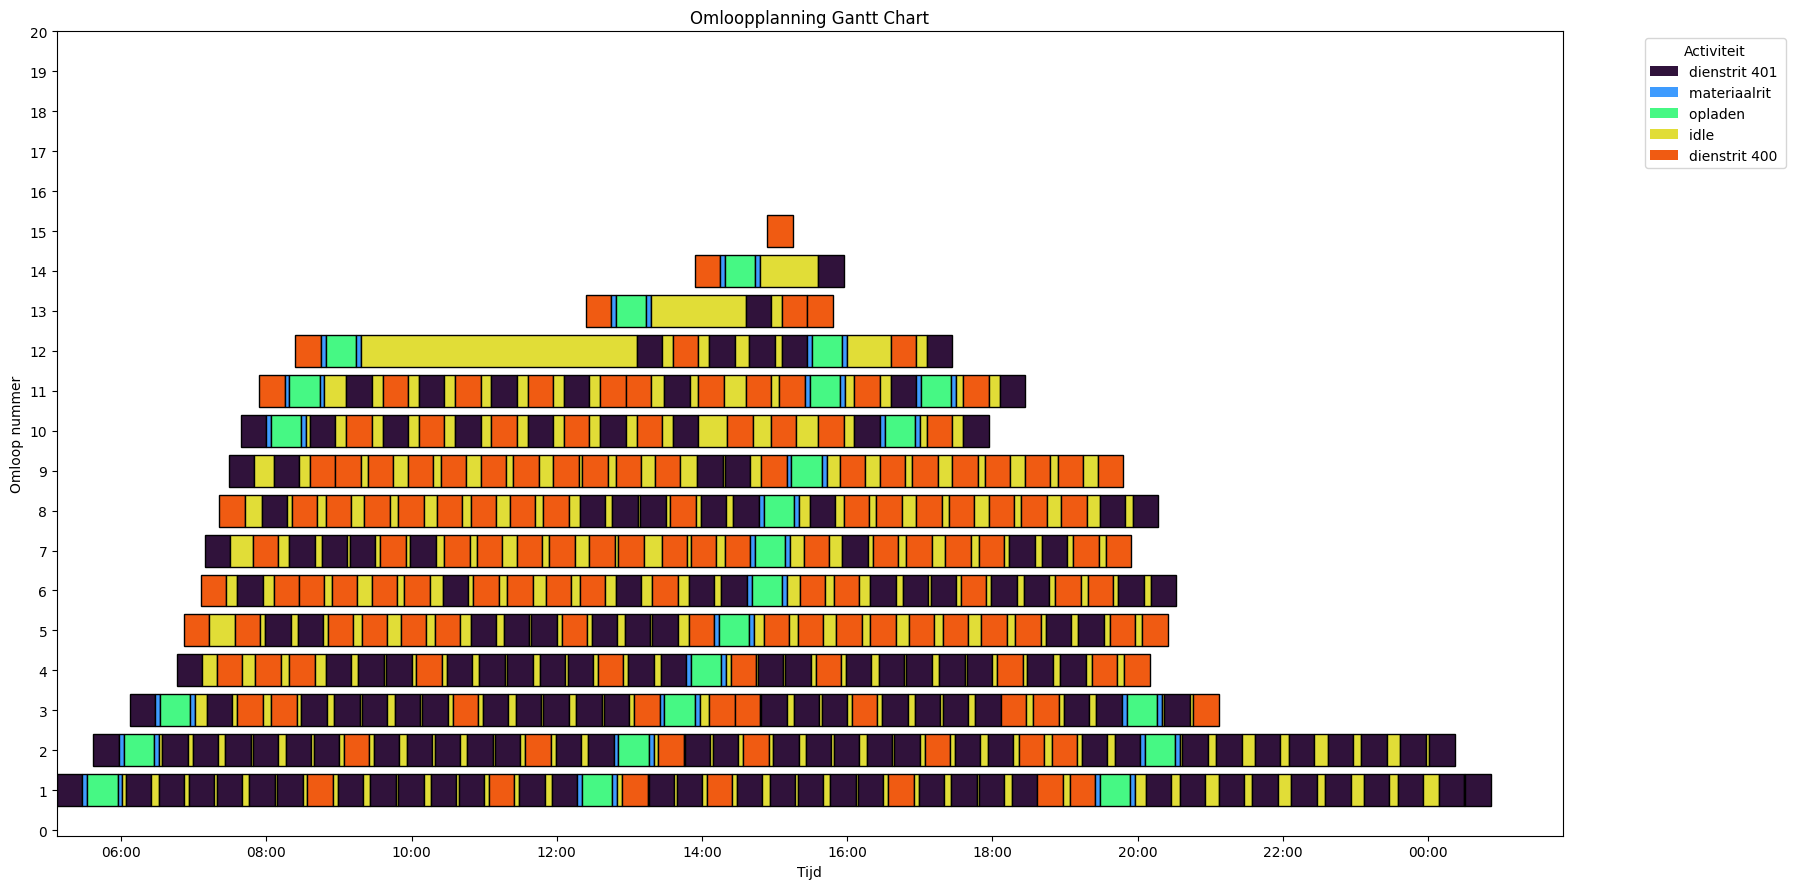

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
import numpy as np

df = df_omloopplanning
# Convert starttijd and eindtijd to datetime for proper plotting
df['starttijd datum'] = pd.to_datetime(df['starttijd datum'])
df['eindtijd datum'] = pd.to_datetime(df['eindtijd datum'])

# Assign a color to each unique activity
df['actieviteitBuslijn'] = df['activiteit'] + ' ' + df['buslijn'].fillna(' ').astype(str)
activities = df['actieviteitBuslijn'].unique()

# Use the updated method to get the colormap
cmap = plt.colormaps.get_cmap('turbo')
colors = [cmap(i / len(activities)) for i in range(len(activities))]

color_dict = {activity: colors[i] for i, activity in enumerate(activities)}

# Create the Gantt chart
fig, ax = plt.subplots(figsize=(18, 9))

for idx, row in df.iterrows():
    ax.barh(row['omloop nummer'], 
            row['eindtijd datum'] - row['starttijd datum'], 
            left=row['starttijd datum'], 
            color=color_dict[row['actieviteitBuslijn']],
            edgecolor='black')

# Format x-axis for time
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


# Format Y-axis for jumps of one
ax.set_yticks(np.arange(0, 21, 1))

# Create legend
legend_elements = [Patch(facecolor=color_dict[activity], label=activity) for activity in activities]
ax.legend(handles=legend_elements, title="Activiteit", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set labels and title
ax.set_xlabel('Tijd')
ax.set_ylabel('Omloop nummer')
ax.set_title('Omloopplanning Gantt Chart')

plt.tight_layout()
plt.savefig('Omloopplanning_Gantt.png')


In [ ]:
df_omloopplanning['eindtijd'] = df_omloopplanning['eindtijd'].dt.strftime('%H:%M:%S')
df_omloopplanning = df_omloopplanning[['startlocatie','eindlocatie','starttijd', 'eindtijd', 'activiteit', 'buslijn', 'energieverbruik', 'starttijd datum', 'eindtijd datum', 'omloop nummer']]
df_omloopplanning.to_excel('5. Verbeterde omloopplanning.xlsx')